In [22]:
import os
os.chdir('/home/jupyter/ntu/csie-cv/hw7')
from PIL import Image
import numpy as np
import copy

In [23]:
img = Image.open('./lena.bmp')
img_array = np.array(img)
width, height = img_array.shape
img_list = img_array.tolist()

In [24]:
def save_image(img, path='./lena.bmp'):
    img_ = Image.fromarray(np.array(img, dtype='uint8'), mode='L')
    img_.save(path)
    return img_

def matrix2text(matrix, file='yokoi_matrix.txt', height=height, width=width):
    with open(file, 'w') as f:
        for y in range(height):
            for x in range(width):
                s = str(matrix[y][x]) if matrix[y][x] else ' '
                f.write(s)
            f.write('\n')

def binarize(img, height=height, width=width):
    for y in range(height):
        for x in range(width):
            img[y][x] = 255 if img[y][x] >= 128 else 0
    return img

def shrink(img, height=height, width=width, scale=2):
    for y in range(0, height, scale):
        for x in range(0, width, scale):
            elm = img[y][x]
            img[y//scale][x//scale] = elm
    img = [ [img[y][x] for x in range(0, width//scale)] for y in range(0, height//scale)]
    return img

In [25]:
# in the manner of [row, col]
k1 = [(0,1),(-1,1),(-1,0)]
k2 = [(-1,0),(-1,-1),(0,-1)]
k3 = [(0,-1),(1,-1),(1,0)]
k4 = [(1,0),(1,1),(0,1)]
k = [(0,1), (-1,0), (0,-1), (1,0)]

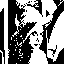

In [26]:
result = copy.deepcopy(img_list)
result = binarize(result)
result = shrink(result, scale=8)
width, height = width//8, height//8 
save_image(result, './binarized_shrink_8.bmp')

# Yokoi connectivity

In [27]:
def h(b, c, d, e):
    """
    b: center
    c: 1st pixel in the kernel, connected with b
    d: 2nd pixel in the kernel
    e: 3rd pixel in the kernel
    """
    bc, bd, be = (b == c, b == d, b==e)
    if not bc:
        return 's'
    elif bd and be:
        return 'r'
    else:
        return 'q'
    
def f(a1, a2, a3, a4):
    cnt = {'s':0,'q':0,'r':0}
    cnt[a1] = cnt[a1]+1
    cnt[a2] = cnt[a2]+1
    cnt[a3] = cnt[a3]+1
    cnt[a4] = cnt[a4]+1

    if cnt['r'] == 4:
        return 5
    else:
        return cnt['q']
    
def get_kernel_pixels(img, y, x, kernel, height=height, width=width):
    return [img[y+y_][x+x_] if 0 <= y+y_ < height and 0 <= x+x_ < width else 0 for y_, x_ in kernel  ]


def yokoi(img, kernels, height=height, width=width):
    matrix = [ [0 for x in range(width)] for y in range(height)]
    for y in range(height):
        for x in range(width):
            if img[y][x]:
                a = []
                for kernel in kernels:
                    a.append(
                        h(img[y][x], *get_kernel_pixels(img, y, x, kernel, height, width))
                        )
                
                matrix[y][x] = f(*a)
    return matrix

# pair relationship operator

In [28]:
def f2(x0, x1, x2, x3, x4):
    if x0 == 1:
        if sum((x1==1, x2==1, x3==1, x4==1)) >= 1:
            return 'p'
        else:
            return 'q'
    else:
        return 'q'
    
def pair_relationship(img, yokoi_matrix, kernel, height=height, width=width):
    matrix = [ [0 for x in range(width)] for y in range(height)]
    for y in range(height):
        for x in range(width):
            if img[y][x] > 0:
                 matrix[y][x] = f2(yokoi_matrix[y][x], *get_kernel_pixels(yokoi_matrix, y, x, kernel, height, width))
    return matrix


# connected shrink operator

In [29]:
def h3(b, c, d, e):
    """
    b: center
    c: 1st pixel in the kernel, connected with b
    d: 2nd pixel in the kernel
    e: 3rd pixel in the kernel
    """
    bc, bd, be = (b == c, b == d, b==e)
    return int(bc and (not bd or not be))
    
def f3(pixel, a1, a2, a3, a4):
        return 0 if sum((a1, a2, a3, a4)) == 1 else pixel

def connected_shrink_operator(img, pr_matrix, kernels, height=height, width=width):
    for y in range(height):
        for x in range(width):
            if img[y][x] > 0 and pr_matrix[y][x] != 'q':
                    a = []
                    for kernel in kernels:
                        a.append(
                            h3(img[y][x], *get_kernel_pixels(img, y, x, kernel, height, width))
                            )
                    img[y][x] = f3(img[y][x], *a)

    return img

In [21]:
origin = copy.deepcopy(result)

i = 1
while True:
    result = copy.deepcopy(origin)
    yokoi_matrix = yokoi(result, [k1, k2, k3, k4])
    pr_matrix = pair_relationship(result, yokoi_matrix, k)
    result = connected_shrink_operator(result, pr_matrix, [k1, k2, k3, k4])
    save_image(result, f'./thinning_{i}.bmp')

    if (np.array(result) == np.array(origin)).all():
        break
    else:
        i += 1
        origin = copy.deepcopy(result)
